In [1]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
FOLD = 0
folds = get_leave_one_out_cv_ids_for_ekyn()
train_ids,test_ids = folds[FOLD]
subjects = [load_eeg_label_pair(id=id,condition=condition,zero_pad=True,windowsize=9) for id in train_ids for condition in ['Vehicle','PF']]
Xs = [subject[0] for subject in subjects]
ys = [subject[1] for subject in subjects]
train_idx,test_idx = train_test_split(range(len(subjects)*8640),test_size=.1,random_state=0,shuffle=True)
trainloader = DataLoader(dataset=SSDataset(Xs,ys,train_idx),batch_size=32,shuffle=True)
devloader = DataLoader(dataset=SSDataset(Xs,ys,test_idx),batch_size=32,shuffle=False)
print(f'trainloader: {len(trainloader)} batches')
print(f'devloader: {len(devloader)} batches')

trainloader: 7290 batches
devloader: 810 batches


In [2]:
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
model = Gandalf()

In [3]:
model.load_state_dict(torch.load(f'../models/gandalfs/gandalf_0/best_model.pt',map_location='cpu'))

<All keys matched successfully>

In [4]:
criterion = torch.nn.CrossEntropyLoss()

In [5]:
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,DEVICE)

  0%|          | 0/810 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 810/810 [00:32<00:00, 24.63it/s]


In [8]:
for y in y_true:
    print(y)

tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(0.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(0.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(0.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(1.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(0.)
tensor(1.)
tensor(2.)
tensor(1.)

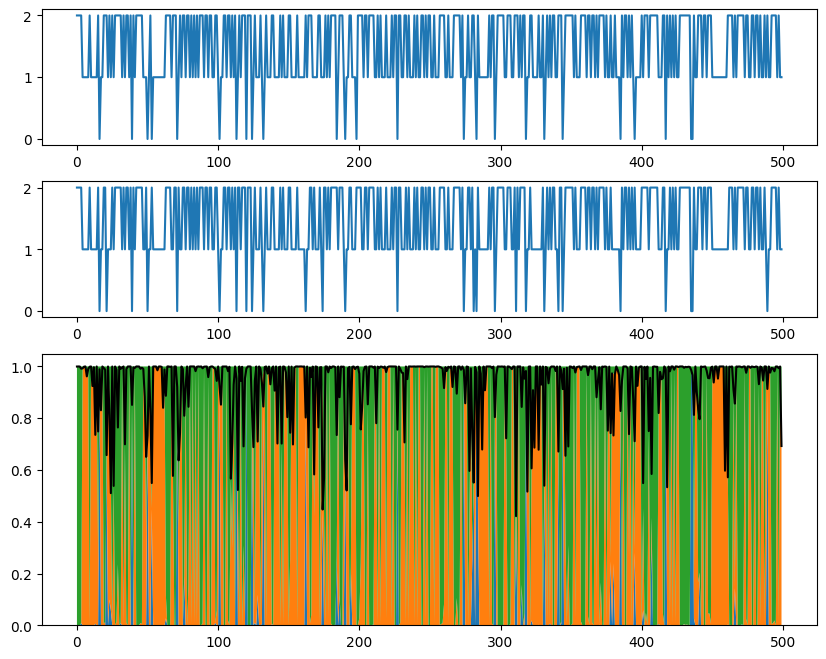

In [6]:
confidences = []
idx = y_logits.argmax(axis=1)
for logit,idx in zip(y_logits,idx):
    confidences.append(logit[idx].item())
fig,axes = plt.subplots(ncols=1,nrows=3,figsize=(10,8),dpi=100,gridspec_kw={'height_ratios': [1,1,2]})
upper = 1000
axes[2].stackplot(torch.arange(len(y_logits[500:upper])),y_logits[500:upper].T)
axes[2].plot(confidences[500:upper],'black')
axes[0].plot(y_true[500:upper])
axes[1].plot(y_pred[500:upper])